# Notebook to demonstrate basic usage of "object oriented NMF" package 

Demonstrate basic usage of NMF package for binarized random data. 

# 1. load libraries, generate data

In [1]:
import sys

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### import OONMF module from above path

In [3]:
sys.path.append('..')
import OONMF

### generate a random matrix of data. 

We binarize the random data by thresholding the values. In this case, I am simulating a relatively sparse data matrix (about 25% density)



In [4]:
def acquire_data(Dim1 = 20, Dim2=40, threshold=0.75):
    # fill in for whatever application
    pass

    data = np.random.rand(Dim1, Dim2)
    data = (data>threshold).astype(int)
    return data

In [5]:
data = acquire_data()

In [6]:
data.shape

(20, 40)

# 2. visualize data and perform non-negative matrix factorization

### quick visualization of random data

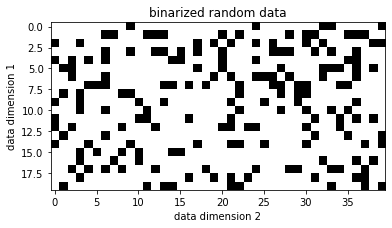

In [7]:
plt.imshow(data, cmap='binary')
plt.title('binarized random data')
plt.ylabel('data dimension 1')
plt.xlabel('data dimension 2')
plt.show()

#### Now we create an object container for the NMF computation and results
#### in this example, we restrict the data to 5 NMF components 

In [8]:
NMFer = OONMF.NMFobject(5)

In [9]:
NMFer.performNMF(data)

starting NMF at  20200412_14:13:58
done with NMF at  20200412_14:13:58
returning reconstruction error


8.93615579728122

#### the NMFer object now contains the decomposed Basis and Mixture  matrices.

#### A quick visualization is shown below

In [10]:
NMFer.Basis.shape

(20, 5)

In [11]:
NMFer.Mixture.shape

(5, 40)

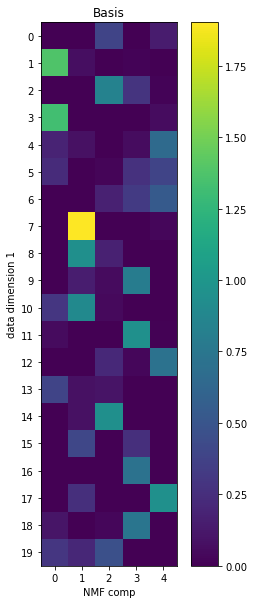

In [12]:
plt.figure(figsize=(5,10))
plt.imshow(NMFer.Basis)
plt.colorbar()
plt.yticks(np.arange(NMFer.Basis.shape[0]))
plt.xticks(np.arange(NMFer.Basis.shape[1]))
plt.xlabel('NMF comp')
plt.ylabel('data dimension 1')
plt.title('Basis')
plt.show()

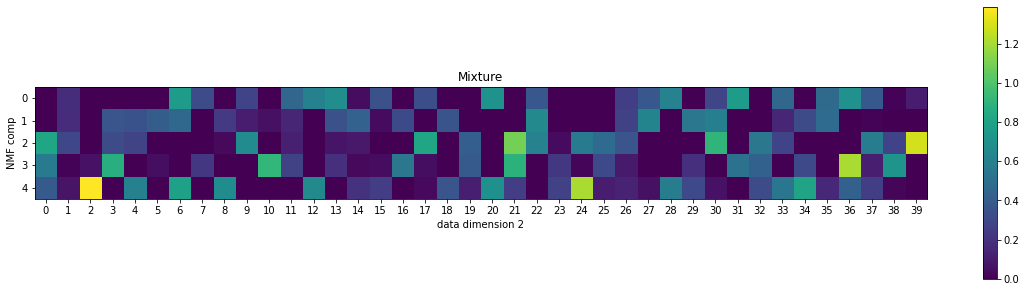

In [13]:
plt.figure(figsize=(20,5))
plt.imshow(NMFer.Mixture)
plt.yticks(np.arange(NMFer.Mixture.shape[0]))
plt.xticks(np.arange(NMFer.Mixture.shape[1]))
plt.ylabel('NMF comp')
plt.xlabel('data dimension 2')
plt.colorbar()
plt.title('Mixture')
plt.show()

### Both decomposed matrices are relatively sparse


# 3. Checking performance 

Using built in function to calculate "classification-like" error - e.g. precision, recall, etc. at a given decision boundary


In [14]:
[sample_PR, total_PR] = NMFer.precision_recall_curve(data)

In [15]:
total_PR.head()

,threshold,TP,FP,TN,FN
0,0.05,184,408,207,1
1,0.10,182,319,296,3
2,0.15,177,245,370,8
3,0.20,169,197,418,16
4,0.25,155,138,477,30


### now calculate error matrices (by hand in this case) 

In [16]:
total_PR['precision'] = total_PR['TP'] / (total_PR['TP'] + total_PR['FP'])
total_PR['recall'] = total_PR['TP'] / (total_PR['TP'] + total_PR['FN'])
total_PR['accuracy'] = (total_PR['TP'] + total_PR['TN']) / (total_PR['TP'] + total_PR['FP'] + total_PR['FN'] + total_PR['TN'])
total_PR['F1'] = 2*total_PR['precision']*total_PR['recall'] / (total_PR['precision']+total_PR['recall'])

In [17]:
total_PR.head(10)

,threshold,TP,FP,TN,FN,precision,recall,accuracy,F1
0,0.05,184,408,207,1,0.310811,0.994595,0.48875,0.473616
1,0.10,182,319,296,3,0.363273,0.983784,0.59750,0.530612
2,0.15,177,245,370,8,0.419431,0.956757,0.68375,0.583196
3,0.20,169,197,418,16,0.461749,0.913514,0.73375,0.613430
4,0.25,155,138,477,30,0.529010,0.837838,0.79000,0.648536
5,0.30,141,102,513,44,0.580247,0.762162,0.81750,0.658879
6,0.35,132,78,537,53,0.628571,0.713514,0.83625,0.668354
7,0.40,127,53,562,58,0.705556,0.686486,0.86125,0.695890
8,0.45,115,42,573,70,0.732484,0.621622,0.86000,0.672515
9,0.50,102,27,588,83,0.790698,0.551351,0.86250,0.649682


### Calculate AUPRC - perhaps best metric of classification accuracy

In [18]:
AUPRC = np.trapz([1] + list(total_PR['recall'].values) + [0], [0] + list(total_PR['precision'].values) +[1])

In [19]:
AUPRC

0.7852639833680519

### AUPRC around 0.8. Not bad, considering we've compressed the data by a factor of ~3

now for some visualization for the reconstruction

<Figure size 432x288 with 0 Axes>

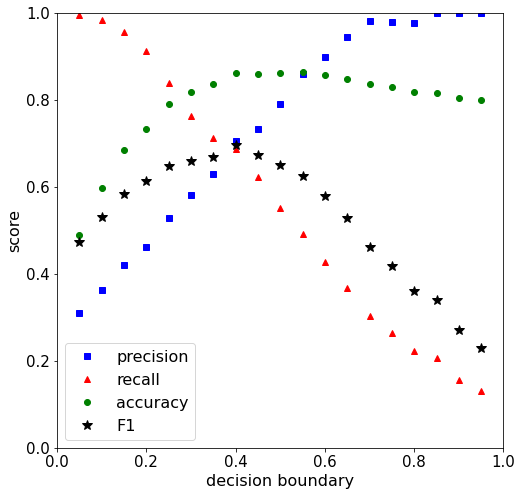

In [20]:
plt.clf()
plt.figure(figsize=(8,8))

plt.plot(total_PR['threshold'], total_PR['precision'], 'sb')
plt.plot(total_PR['threshold'], total_PR['recall'], '^r')
plt.plot(total_PR['threshold'], total_PR['accuracy'], 'og')
plt.plot(total_PR['threshold'], total_PR['F1'], '*k', ms=10)

plt.xlabel('decision boundary', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=15)

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(['precision', 'recall', 'accuracy', 'F1'], fontsize=16)

plt.show()

### manually check reconstruction error and compute final statistic for accuracy

In [21]:
NMFer.build_reconstruction()

In [22]:
NMFer.Reconstruction.shape

(20, 40)

In [23]:
data.shape

(20, 40)

In [24]:
np.sum(np.square((NMFer.Reconstruction - data)))

79.85488043328277

In [25]:
np.sqrt(np.sum(np.square((NMFer.Reconstruction - data))))

8.936155797281222

### average accuracy per matrix element

In [26]:
1 - np.sqrt(np.sum(np.square((NMFer.Reconstruction - data)))) / (data.shape[0] * data.shape[1])

0.9888298052533985